# Abundance maps

Generate large scale maps of abundance of individual branches using a 50km grid.

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Load all buildings represented as points.

In [3]:
complete = gpd.read_parquet("/data/uscuni-boundaries/classification/")

Map ids to level 3.

In [4]:
final_clusters = pd.read_parquet(
    "/data/uscuni-ulce/processed_data/clusters/cluster_mapping_v10.pq"
)
complete["level_3"] = complete.final_without_noise.map(final_clusters[3])

Make a grid

In [5]:
bds = complete.total_bounds
bds

array([4031349.95272902, 2597498.33419905, 5378847.07173358,
       3799811.41843362])

In [104]:
x = np.arange(bds[0], bds[2], 50_000)
y = np.arange(bds[1], bds[3], 50_000)

In [105]:
xs, ys = np.meshgrid(x, y)

In [106]:
grid = gpd.GeoSeries.from_xy(x=xs.flatten(), y=ys.flatten(), crs=complete.crs).buffer(
    25_000, cap_style="square"
)

In [128]:
complete

,geometry,final_without_noise,area,level_3
__null_dask_index__,,,,
0,POINT (4099683.344 3108236.287),90,66.767646,7
1,POINT (4100189.13 3108803.392),85,427.019080,7
2,POINT (4100069.189 3109146.3),88,144.324859,7
3,POINT (4100144.944 3108299.666),102,139.581363,8
4,POINT (4100022.946 3108688.179),85,41.651016,7
...,...,...,...,...
41292,POINT (4180460.733 3188676.499),15,95.975763,2
41293,POINT (4180458.515 3188761.662),99,31.145408,7
41294,POINT (4180462.235 3188947.517),93,28.739082,7


Join grid label to points

In [107]:
grid = grid.to_frame("geometry")
joined = complete.sjoin(grid, predicate="within")

Group by grid label and get counts by class.

In [129]:
counts = joined.groupby("index_right").final_without_noise.value_counts().unstack().fillna(0)
counts = counts.div(counts.sum(axis=1), axis=0)
counts

final_without_noise,1,2,3,4,5,6,7,8,9,10,...,101,102,103,104,105,106,107,108,109,110
index_right,,,,,,,,,,,,,,,,,,,,,
10,0.000769,0.000000,0.000000,0.047290,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0000,0.0,0.000000,0.000000,0.066513,0.0,0.000000,0.0
11,0.001865,0.000000,0.007459,0.011893,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0000,0.0,0.010533,0.007207,0.015522,0.0,0.000000,0.0
12,0.008204,0.010997,0.026254,0.005845,0.002007,0.007723,0.0,0.0,0.0,0.000000,...,0.005011,0.0,0.0002,0.0,0.003685,0.002993,0.009366,0.0,0.000000,0.0
13,0.001107,0.000000,0.000761,0.003321,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0000,0.0,0.006745,0.000000,0.003874,0.0,0.003321,0.0
32,0.000906,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0000,0.0,0.000000,0.000000,0.077271,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647,0.020026,0.000000,0.003038,0.003073,0.000000,0.000000,0.0,0.0,0.0,0.003798,...,0.000000,0.0,0.0000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0
670,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0
671,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0


Plot

In [130]:
grid_data = pd.concat([grid, counts], axis=1)

In [196]:
boundaries = gpd.read_file(
    "/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg",
    layer="1994_political",
)

In [205]:
lt = gpd.read_file(
    "https://media.githubusercontent.com/media/wmgeolab/geoBoundaries/9469f09592ced973a3448cf66b6100b741b64c0d/releaseData/gbOpen/LTU/ADM0/geoBoundaries-LTU-ADM0-all.zip",
    layer="geoBoundaries-LTU-ADM0_simplified",
).to_crs(boundaries.crs)

In [198]:
cmap = [
    "#4069BC",
    "#7CBAE4",
    "#E69C63",
    "#eec1d5",
    "#E0665F",
    "#ECBF43",
    "#b2cd32",
    "#1F943E",
]
cmap = {i: col for i, col in enumerate(cmap, 1)}

names = {
    1: "Incoherent Large-Scale \nHomogeneous Fabric",
    2: "Incoherent Large-Scale \nHeterogeneous Fabric",
    3: "Incoherent Small-Scale \nLinear Fabric",
    4: "Incoherent Small-Scale \nSparse Fabric",
    5: "Incoherent Small-Scale \nCompact Fabric",
    6: "Coherent Interconnected \nFabric",
    7: "Coherent Dense Disjoint \nFabric",
    8: "Coherent Dense Adjacent \nFabric",
}

In [199]:
def plot_label(label, ax):
    grid_data.plot(
        ax=ax,
        color=cmap[label],
        alpha=grid_data[label].fillna(0) / grid_data[label].max(),
    )
    boundaries.boundary.plot(ax=ax, color="k", zorder=2, linewidth=0.5)
    lt.boundary.plot(ax=ax, color="k", zorder=2, linewidth=0.5)

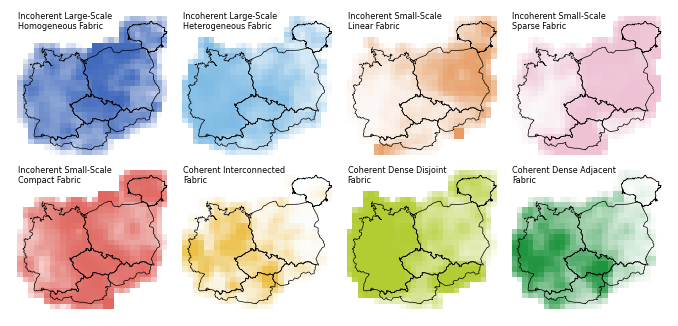

In [204]:
fig, axs = plt.subplots(2, 4, figsize=(8.5, 4), sharex=True, sharey=True)
for label, ax in enumerate(axs.flat, 1):
    plot_label(label, ax)
    ax.set_axis_off()
    ax.text(
        0.05,
        0.99,
        names[label],
        fontsize="xx-small",
        transform=ax.transAxes,
        verticalalignment="top",
    )
fig.subplots_adjust(wspace=0.00, hspace=0.00)
fig.savefig("../data/abundance.png", bbox_inches="tight", dpi=300)

In [27]:
grid_data

,geometry,1,2,3,4,5,6,7,8
10,"POLYGON ((4556349.953 2622498.334, 4556349.953...",0.048058,0.000000,0.076894,0.327566,0.357170,0.000000,0.123799,0.066513
11,"POLYGON ((4606349.953 2622498.334, 4606349.953...",0.021217,0.017739,0.076501,0.446203,0.304389,0.000000,0.100640,0.033311
12,"POLYGON ((4656349.953 2622498.334, 4656349.953...",0.061029,0.020410,0.008427,0.329159,0.335203,0.018215,0.206291,0.021266
13,"POLYGON ((4706349.953 2622498.334, 4706349.953...",0.005189,0.006780,0.114497,0.413747,0.361064,0.006296,0.078280,0.014148
32,"POLYGON ((4306349.953 2672498.334, 4306349.953...",0.000906,0.000000,0.114096,0.523695,0.155448,0.000000,0.128584,0.077271
...,...,...,...,...,...,...,...,...,...
647,"POLYGON ((5356349.953 3772498.334, 5356349.953...",0.026138,0.010807,0.444686,0.191389,0.190456,0.000000,0.136489,0.000035
670,"POLYGON ((5156349.953 3822498.334, 5156349.953...",0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
671,"POLYGON ((5206349.953 3822498.334, 5206349.953...",0.000000,0.000000,0.268827,0.473730,0.247811,0.000000,0.000000,0.009632
672,"POLYGON ((5256349.953 3822498.334, 5256349.953...",0.001770,0.012388,0.308164,0.469679,0.193252,0.000000,0.014748,0.000000


In [14]:
from libpysal.graph import Graph
from esda import Moran_Local

In [132]:
grid_data = grid_data.dropna().reset_index()

In [111]:
contig = Graph.build_contiguity(grid_data, rook=False).transform('r')

lisa = Moran_Local(grid_data[3].fillna(0), contig)

In [84]:
boundaries = []
for i in range(1, 9):
    for p in [0.1, 0.05, 0.01]:
        lisa = Moran_Local(grid_data[i].fillna(0), contig)
        lisa_graph = Graph.build_block_contiguity(lisa.get_cluster_labels() == "High-High")
        inter = contig.difference(lisa_graph)
        boundaries.append(inter)

        lisa_graph = Graph.build_block_contiguity(lisa.get_cluster_labels() == "Low-Low")
        inter = contig.difference(lisa_graph)
        boundaries.append(inter)

In [44]:
lisa_graph = Graph.build_block_contiguity(lisa.get_cluster_labels() == "High-High")

In [52]:
inter = contig.difference(lisa_graph)

In [54]:
inter.explore(grid_data, nodes=False)

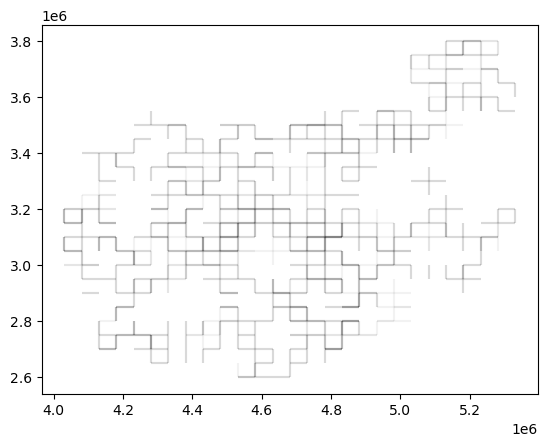

In [70]:
f, ax = plt.subplots()

for bound in boundaries:
    bound.plot(grid_data, ax=ax, nodes=False, edge_kws=dict(alpha=.05))

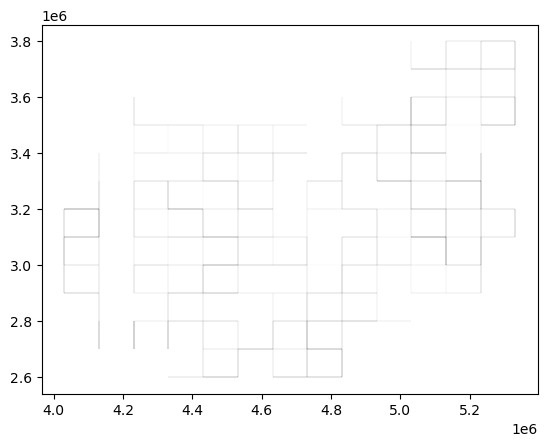

In [86]:
f, ax = plt.subplots()

for bound in boundaries:
    bound.plot(grid_data, ax=ax, nodes=False, edge_kws=dict(alpha=.01))

In [87]:
from sklearn.decomposition import PCA

In [92]:
grid_data.iloc[:, :]

,index,geometry,1,2,3,4,5,6,7,8
0,3,"POLYGON ((4381349.953 2647498.334, 4381349.953...",0.003155,0.000000,0.525762,0.202419,0.134595,0.000000,0.000000,0.134069
1,4,"POLYGON ((4481349.953 2647498.334, 4481349.953...",0.018433,0.019585,0.296083,0.552995,0.000000,0.000000,0.000000,0.112903
2,5,"POLYGON ((4581349.953 2647498.334, 4581349.953...",0.016216,0.010794,0.133322,0.449530,0.271250,0.002303,0.073700,0.042884
3,6,"POLYGON ((4681349.953 2647498.334, 4681349.953...",0.039414,0.013280,0.046289,0.436355,0.286800,0.009161,0.146008,0.022693
4,7,"POLYGON ((4781349.953 2647498.334, 4781349.953...",0.020484,0.011766,0.056872,0.574936,0.243468,0.004815,0.071042,0.016615
...,...,...,...,...,...,...,...,...,...,...
123,167,"POLYGON ((5381349.953 3747498.334, 5381349.953...",0.014232,0.005392,0.479768,0.257846,0.135323,0.000000,0.107407,0.000033
124,178,"POLYGON ((5081349.953 3847498.334, 5081349.953...",0.036328,0.028433,0.103338,0.285279,0.275685,0.000000,0.249350,0.021587
125,179,"POLYGON ((5181349.953 3847498.334, 5181349.953...",0.035063,0.006765,0.081218,0.347230,0.308647,0.000000,0.211382,0.009695
126,180,"POLYGON ((5281349.953 3847498.334, 5281349.953...",0.010641,0.002860,0.268585,0.315998,0.262257,0.000000,0.138161,0.001497


In [133]:
pca = PCA(3).fit(grid_data.iloc[:, 2:].values)

In [134]:
pca.explained_variance_ratio_

array([0.23489325, 0.10328756, 0.07577708])

In [135]:
comps = pca.transform(grid_data.iloc[:, 2:].values)

In [143]:
lisa_comp = Moran_Local(comps[:, 2], contig)

In [144]:
lisa_comp.explore(grid_data)

<Axes: >

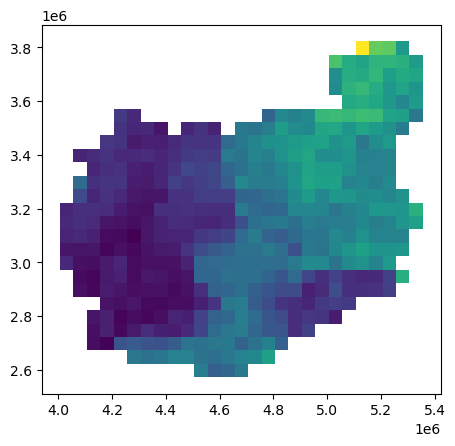

In [147]:
grid_data.plot(comps[:, 0])

<Axes: >

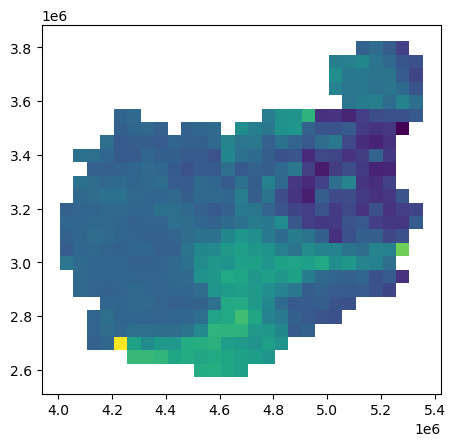

In [139]:
grid_data.plot(comps[:, 1])

<Axes: >

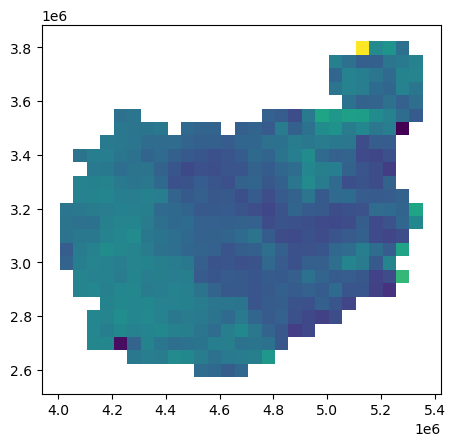

In [140]:
grid_data.plot(comps[:, 2])